In [1]:
# Standard library imports
import os

import xml.etree.ElementTree as ET

# TensorFlow and image processing
import tensorflow as tf
from PIL import Image

# Scikit-learn for model evaluation and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Matplotlib and Seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
# Define paths to your datasets
bccd_annotations_dir = './BCCD_Dataset/BCCD/Annotations'
bccd_images_dir = './BCCD_Dataset/BCCD/Images'
cbc_annotations_dir = './Complete-Blood-Cell-Count-Dataset/Training/Annotations'
cbc_images_dir = './Complete-Blood-Cell-Count-Dataset/Training/Images'

# Function to parse annotation files
def parse_annotations(annotations_dir, images_dir, prefix):
    data = []
    for filename in os.listdir(annotations_dir):
        if filename.endswith('.xml'):
            tree = ET.parse(os.path.join(annotations_dir, filename))
            root = tree.getroot()
            image_filename = filename.replace('.xml', '.jpg')
            image_path = os.path.join(images_dir, image_filename)
            objects = root.findall('object')
            for obj in objects:
                class_name = obj.find('name').text
                bbox = obj.find('bndbox')
                bbox_coords = {
                    'xmin': int(bbox.find('xmin').text),
                    'ymin': int(bbox.find('ymin').text),
                    'xmax': int(bbox.find('xmax').text),
                    'ymax': int(bbox.find('ymax').text)
                }
                data.append({
                    'image_path': image_path,
                    'class': class_name,
                    'bbox': bbox_coords,
                    'prefix': prefix
                })
    return data

# Load BCCD dataset
bccd_data = parse_annotations(bccd_annotations_dir, bccd_images_dir, 'BCCD')

# Load CBC dataset
cbc_data = parse_annotations(cbc_annotations_dir, cbc_images_dir, 'CBC')

# Combine datasets
combined_data = bccd_data + cbc_data

# Print summary of loaded data
print(f'Total BCCD data items: {len(bccd_data)}')
print(f'Total CBC data items: {len(cbc_data)}')
print(f'Total combined data items: {len(combined_data)}')


Total BCCD data items: 4888
Total CBC data items: 3952
Total combined data items: 8840


In [2]:
# Define directories
bccd_image_dir = './BCCD_Dataset/BCCD/JPEGImages'
bccd_annotation_dir = './BCCD_Dataset/BCCD/Annotations'

cbc_image_dirs = [
    './Complete-Blood-Cell-Count-Dataset/Training/Images',
    './Complete-Blood-Cell-Count-Dataset/Validation/Images',
    './Complete-Blood-Cell-Count-Dataset/Testing/Images'
]
cbc_annotation_dirs = [
    './Complete-Blood-Cell-Count-Dataset/Training/Annotations',
    './Complete-Blood-Cell-Count-Dataset/Validation/Annotations',
    './Complete-Blood-Cell-Count-Dataset/Testing/Annotations'
]

pbc_image_dirs = [
    './PBC_dataset_normal_DIB/basophil',
    './PBC_dataset_normal_DIB/eosinophil',
    './PBC_dataset_normal_DIB/erythroblast',
    './PBC_dataset_normal_DIB/ig',
    './PBC_dataset_normal_DIB/lymphocyte',
    './PBC_dataset_normal_DIB/monocyte',
    './PBC_dataset_normal_DIB/neutrophil',
    './PBC_dataset_normal_DIB/platelet'
]

# Verify directories existence
for dir_path in [bccd_image_dir] + cbc_image_dirs + pbc_image_dirs:
    if not os.path.exists(dir_path):
        raise FileNotFoundError(f"Directory not found: {dir_path}")

# Create unified dataset directory
unified_image_dir = './unified_dataset/Images'
os.makedirs(unified_image_dir, exist_ok=True)

def create_symlink_with_prefix(image_dir, prefix):
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            src = os.path.join(image_dir, filename)
            dst = os.path.join(unified_image_dir, f"{prefix}_{filename}")
            try:
                os.symlink(src, dst)
            except FileExistsError:
                print(f"Warning: Skipping duplicate image {dst}")

# Create symbolic links with prefixes to avoid naming conflicts
create_symlink_with_prefix(bccd_image_dir, 'bccd')

for i, dir_path in enumerate(cbc_image_dirs):
    create_symlink_with_prefix(dir_path, f'cbc_{i}')

for i, dir_path in enumerate(pbc_image_dirs):
    create_symlink_with_prefix(dir_path, f'pbc_{i}')

print("Unified dataset created successfully.")

Unified dataset created successfully.


In [3]:
def get_bccd_classes(annotation_dir):
    classes = set()
    for filename in os.listdir(annotation_dir):
        if filename.endswith('.xml'):
            tree = ET.parse(os.path.join(annotation_dir, filename))
            root = tree.getroot()
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                classes.add(class_name)
    return classes

bccd_annotation_dir = './BCCD_Dataset/BCCD/Annotations'
bccd_classes = get_bccd_classes(bccd_annotation_dir)
print(f"BCCD Classes: {bccd_classes}")

cbc_annotation_dirs = [
    './Complete-Blood-Cell-Count-Dataset/Testing/Annotations',
    './Complete-Blood-Cell-Count-Dataset/Training/Annotations',
    './Complete-Blood-Cell-Count-Dataset/Validation/Annotations'
]

cbc_classes = set()
for dir_path in cbc_annotation_dirs:
    cbc_classes.update(get_bccd_classes(dir_path))

print(f"CBC Classes: {cbc_classes}")

pbc_classes = set(os.listdir('./PBC_dataset_normal_DIB'))
print(f"PBC Classes: {pbc_classes}")

# Combine all classes
all_classes = bccd_classes.union(cbc_classes).union(pbc_classes)
print(f"All Classes: {all_classes}")
num_classes = len(all_classes)

# Create a mapping from class names to indices
class_to_index = {cls: idx for idx, cls in enumerate(all_classes)}
print(f"Class to Index Mapping: {class_to_index}")


BCCD Classes: {'WBC', 'RBC', 'Platelets'}
CBC Classes: {'RBC', 'WBC', 'Platelets'}
PBC Classes: {'monocyte', 'basophil', 'platelet', 'eosinophil', 'erythroblast', 'lymphocyte', 'neutrophil', 'ig'}
All Classes: {'WBC', 'RBC', 'monocyte', 'basophil', 'platelet', 'eosinophil', 'erythroblast', 'lymphocyte', 'Platelets', 'neutrophil', 'ig'}
Class to Index Mapping: {'WBC': 0, 'RBC': 1, 'monocyte': 2, 'basophil': 3, 'platelet': 4, 'eosinophil': 5, 'erythroblast': 6, 'lymphocyte': 7, 'Platelets': 8, 'neutrophil': 9, 'ig': 10}


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Directory paths
bccd_dir = './BCCD_Dataset/BCCD/JPEGImages/'
cbcc_dir = './Complete-Blood-Cell-Count-Dataset/Training/Images/'
pbc_dir = './PBC_dataset_normal_DIB/'

# Class names and indices
class_names = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'Lymphocyte', 
               'monocyte', 'neutrophil', 'platelet', 'RBC', 'WBC', 'other']
class_to_index = {name: index for index, name in enumerate(class_names)}

# Function to check if an image file is valid
def is_valid_image(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Verify that it is an image
        return True
    except (IOError, SyntaxError) as e:
        print(f"Invalid image file: {image_path} - {e}")
        return False

# Get all file paths and corresponding labels
def get_all_files_and_labels():
    all_files = []
    for class_name in class_names:
        # PBC dataset
        pbc_class_dir = os.path.join(pbc_dir, class_name)
        if os.path.isdir(pbc_class_dir):
            pbc_files = [os.path.join(pbc_class_dir, f) for f in os.listdir(pbc_class_dir) if f.endswith('.jpg')]
            valid_pbc_files = [(f, class_to_index[class_name]) for f in pbc_files if is_valid_image(f)]
            all_files.extend(valid_pbc_files)

        # BCCD dataset
        bccd_files = [os.path.join(bccd_dir, f) for f in os.listdir(bccd_dir) if f.endswith('.jpg')]
        valid_bccd_files = [(f, class_to_index['RBC'] if 'RBC' in f else class_to_index['WBC'] if 'WBC' in f else class_to_index['platelet']) for f in bccd_files if is_valid_image(f)]
        all_files.extend(valid_bccd_files)

        # CBCC dataset
        cbcc_files = [os.path.join(cbcc_dir, f) for f in os.listdir(cbcc_dir) if f.endswith('.jpg')]
        valid_cbcc_files = [(f, class_to_index['RBC'] if 'RBC' in f else class_to_index['WBC'] if 'WBC' in f else class_to_index['platelet']) for f in cbcc_files if is_valid_image(f)]
        all_files.extend(valid_cbcc_files)

    return all_files

all_files_and_labels = get_all_files_and_labels()

# Create a TensorFlow dataset
file_paths, labels = zip(*all_files_and_labels)
list_ds = tf.data.Dataset.from_tensor_slices((list(file_paths), list(labels)))
print("list_ds:")
print(list_ds)


Invalid image file: ./PBC_dataset_normal_DIB/neutrophil\.DS_169665.jpg - cannot identify image file './PBC_dataset_normal_DIB/neutrophil\\.DS_169665.jpg'
list_ds:
<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>


In [5]:
# Define the parse function for the datasets
def parse_function(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    return image, label

# Apply the parse function and batch the datasets
train_ds = list_ds.map(parse_function, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

# Ensure there are batches to process
assert tf.data.experimental.cardinality(train_ds).numpy() > 0, "The dataset is empty!"
print("Dataset after batching and prefetching:")
for batch in train_ds.take(1):
    print(batch)


Dataset after batching and prefetching:
(<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[250.91797, 227.91797, 195.91797],
         [249.28125, 226.28125, 194.28125],
         [246.38672, 223.38672, 191.38672],
         ...,
         [248.44983, 229.01953, 196.01953],
         [251.68604, 228.80396, 197.80396],
         [234.02344, 208.10547, 180.85938]],

        [[252.     , 229.     , 197.     ],
         [252.82312, 229.82312, 197.82312],
         [250.22266, 227.22266, 195.22266],
         ...,
         [252.53955, 229.80103, 198.80103],
         [241.73438, 215.3103 , 192.38062],
         [217.2926 , 186.20776, 171.30823]],

        [[249.9447 , 226.9447 , 194.9447 ],
         [251.41016, 228.41016, 196.41016],
         [250.19226, 227.19226, 195.19226],
         ...,
         [249.20007, 223.73132, 195.13757],
         [226.81458, 196.41772, 178.70886],
         [211.27795, 176.27795, 171.64514]],

        ...,

        [[251.     , 230.     , 203.     ],
  

In [6]:
# Define data augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)

In [7]:
# Split the dataset into training and testing sets (80% training, 20% testing)
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

# Create TensorFlow datasets for training and testing
train_ds = tf.data.Dataset.from_tensor_slices((list(train_files), list(train_labels)))
test_ds = tf.data.Dataset.from_tensor_slices((list(test_files), list(test_labels)))

# Apply the parse function and batch the datasets
train_ds = train_ds.map(parse_function, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
test_ds = test_ds.map(parse_function, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

# Ensure there are batches to process
assert tf.data.experimental.cardinality(train_ds).numpy() > 0, "The training dataset is empty!"
assert tf.data.experimental.cardinality(test_ds).numpy() > 0, "The testing dataset is empty!"

print("Training dataset:")
for batch in train_ds.take(1):
    print(batch)

print("Testing dataset:")
for batch in test_ds.take(1):
    print(batch)


Training dataset:
(<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[255.     , 230.17175, 199.3706 ],
         [250.40698, 224.40698, 190.5625 ],
         [241.68091, 209.27014, 188.02856],
         ...,
         [201.8125 , 165.40625, 161.875  ],
         [216.85156, 176.69531, 171.28906],
         [241.0155 , 214.203  , 186.828  ]],

        [[241.05151, 214.07458, 186.12573],
         [223.16797, 189.83374, 176.21265],
         [212.92993, 175.17603, 172.00806],
         ...,
         [200.875  , 163.59949, 163.80676],
         [209.86328, 168.88391, 167.10327],
         [233.33594, 205.61719, 182.42114]],

        [[219.68689, 185.22925, 177.17517],
         [210.38306, 171.49841, 173.44739],
         [210.53125, 170.71228, 165.97571],
         ...,
         [198.8164 , 161.41016, 163.8789 ],
         [207.40625, 166.0841 , 166.61304],
         [233.6211 , 205.8086 , 184.4336 ]],

        ...,

        [[253.58984, 232.58984, 205.58984],
         [253.58984, 232

In [8]:
# Define the model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

# Train the model
history = model.fit(train_ds, epochs=10)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [9]:
# Print the history dictionary
print(history.history)


{'loss': [1.0619374513626099, 0.22026710212230682, 0.1557592898607254, 0.12836365401744843, 0.11484354734420776, 0.09599589556455612, 0.08918590098619461, 0.08288821578025818, 0.08951322734355927, 0.07019852101802826], 'accuracy': [0.8085673451423645, 0.9234474301338196, 0.9466078877449036, 0.9568046927452087, 0.9594691395759583, 0.9675650596618652, 0.9707419276237488, 0.9719204902648926, 0.969409704208374, 0.9759684205055237]}


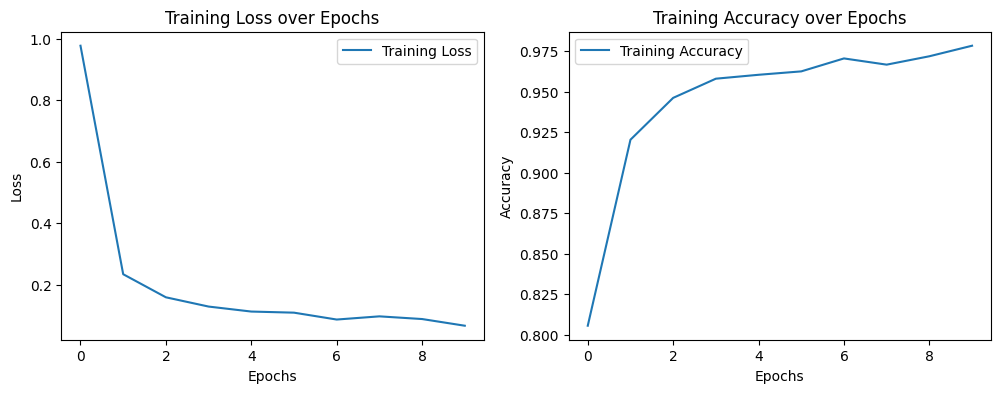

In [9]:
# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history.get('loss', []), label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history.get('accuracy', []), label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.show()



153/153 [==============================] - 13s 86ms/step
              precision    recall  f1-score   support

    basophil       0.94      0.94      0.94       238
  eosinophil       0.99      1.00      0.99       663
erythroblast       0.89      0.96      0.92       290
          ig       0.91      0.86      0.89       596
  Lymphocyte       0.97      0.95      0.96       243
    monocyte       0.91      0.84      0.87       280
  neutrophil       0.92      0.98      0.95       665
    platelet       1.00      1.00      1.00      1905

    accuracy                           0.96      4880
   macro avg       0.94      0.94      0.94      4880
weighted avg       0.96      0.96      0.96      4880



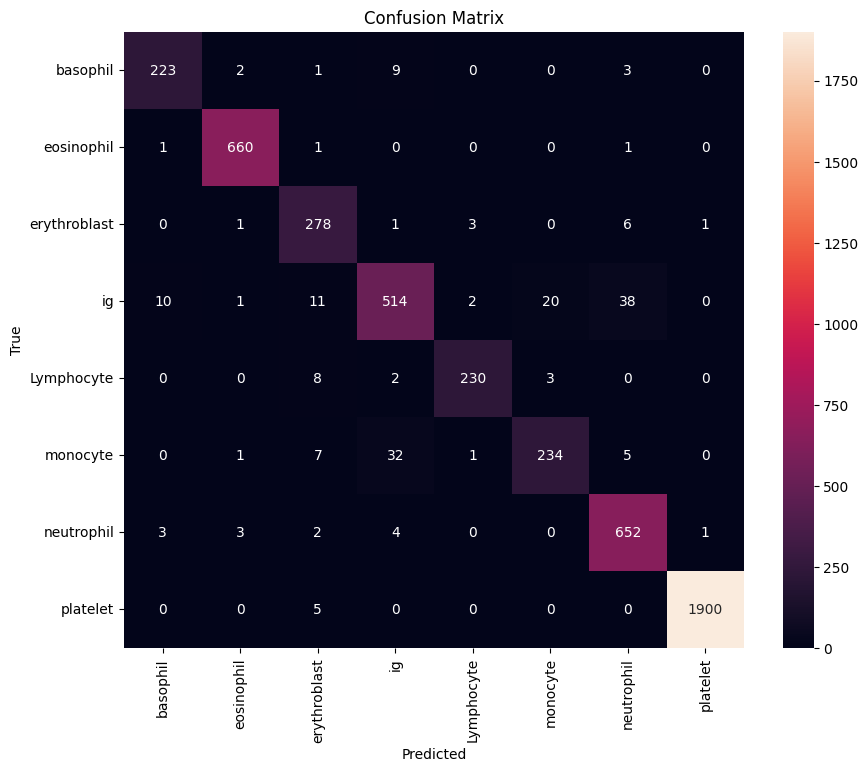

In [10]:
# Get predictions
y_pred = model.predict(test_ds)
y_pred_classes = tf.argmax(y_pred, axis=1)

# Get true labels
y_true = tf.concat([y for x, y in test_ds], axis=0)

# Ensure both y_true and y_pred_classes are in the same format
y_true = y_true.numpy()
y_pred_classes = y_pred_classes.numpy()

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names[:8])  # Assuming only 8 classes are present in test data
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, labels=list(range(8)))  # Labels are indices of the present classes

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names[:8], yticklabels=class_names[:8])  # Assuming only 8 classes are present
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [11]:
# Save the entire model as a SavedModel.
model.save('model/my_model')


INFO:tensorflow:Assets written to: model/my_model\assets


INFO:tensorflow:Assets written to: model/my_model\assets


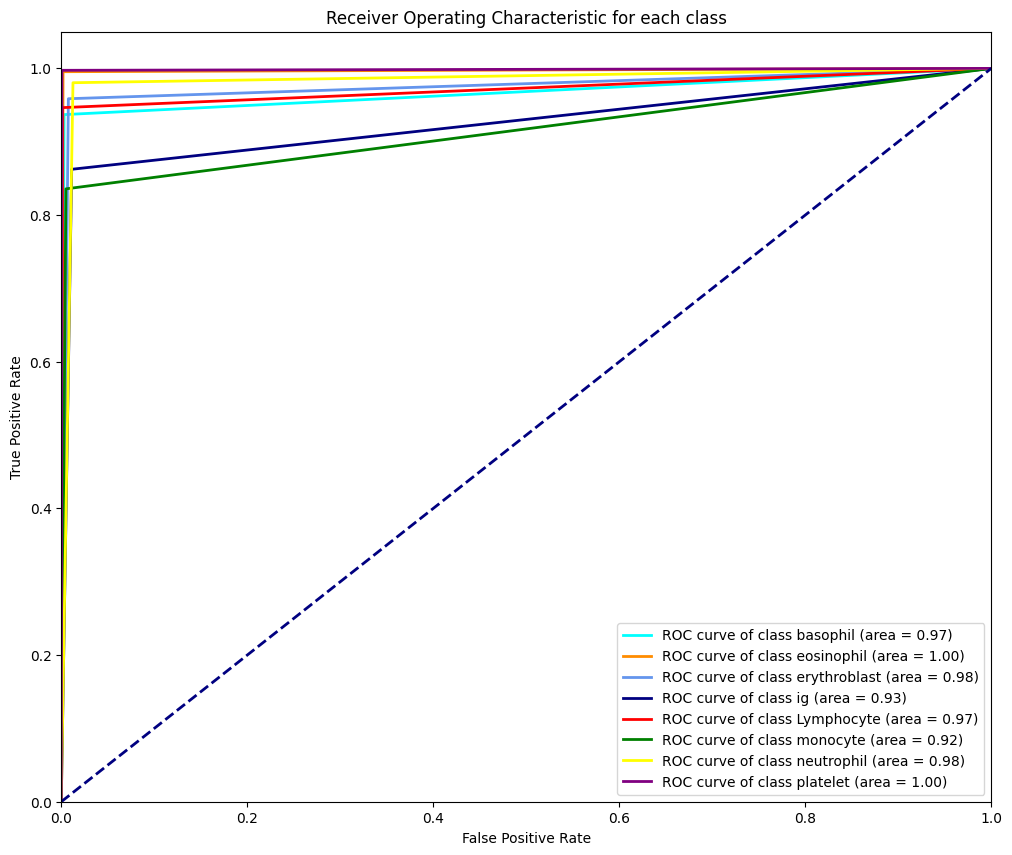

In [12]:
# Assuming y_true and y_pred are your true and predicted labels respectively
n_classes = len(class_names)

# Binarize the output
y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))
y_pred_binarized = label_binarize(y_pred_classes, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    if y_true_binarized[:, i].sum() == 0:
        continue  # Skip classes with no positive samples in y_true
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12, 10))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'navy', 'red', 'green', 'yellow', 'purple', 'pink', 'brown', 'grey']
for i in range(n_classes):
    if i in fpr:  # Plot only for classes with valid ROC values
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


In [44]:
!pip install opencv-python


     ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
     --------------------------------------- 0.0/39.5 MB 435.7 kB/s eta 0:01:31
     --------------------------------------- 0.1/39.5 MB 651.6 kB/s eta 0:01:01
     ---------------------------------------- 0.2/39.5 MB 1.4 MB/s eta 0:00:29
      --------------------------------------- 0.5/39.5 MB 2.4 MB/s eta 0:00:17
     - -------------------------------------- 1.1/39.5 MB 4.3 MB/s eta 0:00:09
     -- ------------------------------------- 2.2/39.5 MB 7.4 MB/s eta 0:00:06
     --- ------------------------------------ 3.5/39.5 MB 10.0 MB/s eta 0:00:04
     ---- ----------------------------------- 4.7/39.5 MB 12.4 MB/s eta 0:00:03
     ----- ---------------------------------- 5.7/39.5 MB 13.6 MB/s eta 0:00:03
     ------ --------------------------------- 6.7/39.5 MB 14.3 MB/s eta 0:00:03
     ------- -------------------------------- 7.8/39.5 MB 15


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image

image_dir = r'C:\Users\ADMIN\OneDrive\Documents\Code\TTCS\Blood-Cell-Classification-main\BCCD_Dataset\BCCD\JPEGImages'
annotation_dir = r'C:\Users\ADMIN\OneDrive\Documents\Code\TTCS\Blood-Cell-Classification-main\BCCD_Dataset\BCCD\Annotations'
mask_dir = r'C:\Users\ADMIN\OneDrive\Documents\Code\TTCS\Blood-Cell-Classification-main\BCCD_Dataset\BCCD\mask'

os.makedirs(mask_dir, exist_ok=True)

for xml_file in os.listdir(annotation_dir):
    if not xml_file.endswith('.xml'):
        continue
    xml_path = os.path.join(annotation_dir, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()
    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    mask = np.zeros((height, width), dtype=np.uint8)

    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), 255, -1)  # tô trắng vùng có tế bào

    mask_img = Image.fromarray(mask)
    mask_img.save(os.path.join(mask_dir, filename.replace('.jpg', '.png')))


In [49]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

def load_images_and_masks(image_dir, mask_dir, img_size=(128, 128)):
    images, masks = [], []
    filenames = os.listdir(image_dir)

    for file in filenames:
        img_path = os.path.join(image_dir, file)
        
        # Giả sử mask đổi phần mở rộng sang .png
        mask_file = file.replace(".jpg", ".png").replace(".jpeg", ".png")
        mask_path = os.path.join(mask_dir, mask_file)

        if not os.path.exists(mask_path):
            continue  # Bỏ qua nếu không có mask

        # Load ảnh và mask
        img = Image.open(img_path).resize(img_size)
        mask = Image.open(mask_path).resize(img_size).convert("L")

        images.append(np.array(img) / 255.0)
        masks.append(np.array(mask) / 255.0)

    print(f"Đã load {len(images)} ảnh có mask hợp lệ.")
    return np.array(images), np.array(masks)[..., np.newaxis]

image_dir = r'C:\Users\ADMIN\OneDrive\Documents\Code\TTCS\Blood-Cell-Classification-main\BCCD_Dataset\BCCD\JPEGImages'
mask_dir = r'C:\Users\ADMIN\OneDrive\Documents\Code\TTCS\Blood-Cell-Classification-main\BCCD_Dataset\BCCD\mask'

X, Y = load_images_and_masks(image_dir, mask_dir)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)


Đã load 364 ảnh có mask hợp lệ.


In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
    u4 = layers.UpSampling2D()(c3)
    u4 = layers.Concatenate()([u4, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D()(c4)
    u5 = layers.Concatenate()([u5, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    model = models.Model(inputs, outputs)
    return model

model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_43 (Conv2D)          (None, 128, 128, 16)         448       ['input_3[0][0]']             
                                                                                                  
 conv2d_44 (Conv2D)          (None, 128, 128, 16)         2320      ['conv2d_43[0][0]']           
                                                                                                  
 max_pooling2d_13 (MaxPooli  (None, 64, 64, 16)           0         ['conv2d_44[0][0]']           
 ng2D)                                                                                      

In [58]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=16
)


Epoch 1/50
21/21 [==============================] - 13s 633ms/step - loss: 0.1187 - accuracy: 0.9107 - val_loss: 0.8273 - val_accuracy: 0.7445
Epoch 2/50
21/21 [==============================] - 12s 574ms/step - loss: 0.1203 - accuracy: 0.9098 - val_loss: 0.8155 - val_accuracy: 0.7447
Epoch 3/50
21/21 [==============================] - 12s 593ms/step - loss: 0.1166 - accuracy: 0.9114 - val_loss: 0.8299 - val_accuracy: 0.7448
Epoch 4/50
21/21 [==============================] - 12s 597ms/step - loss: 0.1183 - accuracy: 0.9105 - val_loss: 0.8438 - val_accuracy: 0.7431
Epoch 5/50
21/21 [==============================] - 13s 633ms/step - loss: 0.1230 - accuracy: 0.9090 - val_loss: 0.8270 - val_accuracy: 0.7421
Epoch 6/50
21/21 [==============================] - 12s 589ms/step - loss: 0.1230 - accuracy: 0.9088 - val_loss: 0.8389 - val_accuracy: 0.7401
Epoch 7/50
21/21 [==============================] - 12s 588ms/step - loss: 0.1172 - accuracy: 0.9111 - val_loss: 0.8437 - val_accuracy: 0.7449

In [ ]:
model.save(r"C:\Users\ADMIN\OneDrive\Documents\Code\TTCS\Blood-Cell-Classification-main\model\my_model\segmentation_model.h5")


c:\Users\ADMIN\OneDrive\Documents\Code\TTCS\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Load model segmentation đã train
model = load_model(r"C:\Users\ADMIN\OneDrive\Documents\Code\TTCS\Blood-Cell-Classification-main\model\my_model\segmentation_model.h5")  # Đường dẫn tới model segmentation

def predict_mask(img_path, model, target_size=(128, 128)):
    # Load và resize ảnh gốc
    original_img = load_img(img_path)
    img = original_img.resize(target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # (1, 128, 128, 3)

    # Dự đoán
    pred = model.predict(img_array)[0]  # (128, 128, 1)
    pred_mask = (pred > 0.5).astype(np.uint8)  # Nhị phân hóa

    return original_img, pred[..., 0], pred_mask[..., 0]


1/1 [==============================] - 0s 218ms/step


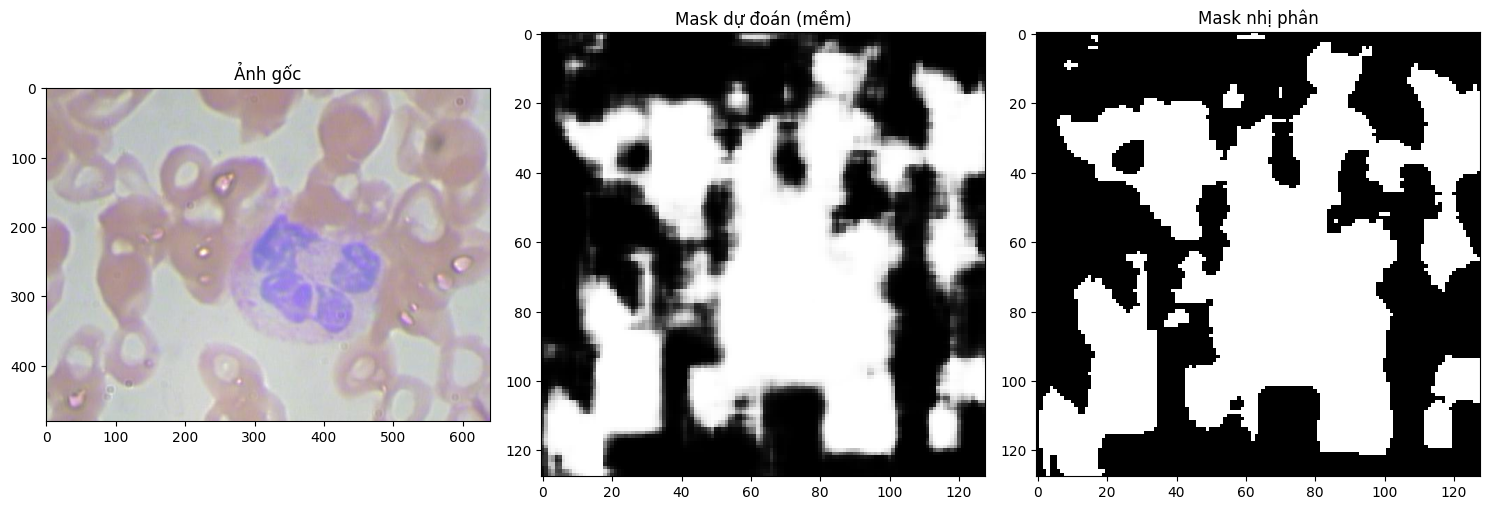

: 

In [ ]:
img_path = r"C:\Users\ADMIN\OneDrive\Documents\Code\TTCS\Blood-Cell-Classification-main\BCCD_Dataset\BCCD\JPEGImages\BloodImage_00000.jpg"  # Thay bằng ảnh thật

original_img, pred_mask, bin_mask = predict_mask(img_path, model)

# Hiển thị kết quả
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title("Ảnh gốc")

plt.subplot(1, 3, 2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Mask dự đoán (mềm)")

plt.subplot(1, 3, 3)
plt.imshow(bin_mask, cmap="gray")
plt.title("Mask nhị phân")

plt.tight_layout()
plt.show()


In [1]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import cv2
from stardist.models import StarDist2D
from csbdeep.utils import normalize
import tensorflow as tf

# Load mô hình phân vùng và phân loại
segment_model = StarDist2D(None, name='my_stardist_model', basedir=r'C:\Users\ADMIN\OneDrive\Documents\Code\TTCS')  # đường dẫn đến mô hình stardist
classify_model = tf.keras.models.load_model(r'C:\Users\ADMIN\OneDrive\Documents\Code\TTCS\Blood-Cell-Classification-main\model\my_model')  # đường dẫn model phân loại

# Danh sách nhãn (theo thứ tự training)
class_names = ['RBC', 'WBC', 'Platelet']

# Hàm xử lý ảnh
def process_image(path):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Nếu model StarDist chỉ huấn luyện trên ảnh xám, convert:
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    img_norm = normalize(img_gray)

    # Phân vùng tế bào
    labels, _ = segment_model.predict_instances(img_norm)

    result = img_rgb.copy()

    for region_id in np.unique(labels):
        if region_id == 0:
            continue
        mask = (labels == region_id).astype(np.uint8) * 255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue

        x, y, w, h = cv2.boundingRect(contours[0])
        cell_img = img_rgb[y:y+h, x:x+w]
        if cell_img.shape[0] < 10 or cell_img.shape[1] < 10:
            continue

        resized = cv2.resize(cell_img, (128, 128)) / 255.0
        pred = classify_model.predict(np.expand_dims(resized, axis=0), verbose=0)
        label = class_names[np.argmax(pred)]

        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    return result

# Tkinter GUI
def browse_file():
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.png *.jpeg")])
    if not file_path:
        return
    output_img = process_image(file_path)

    # Hiển thị ảnh kết quả
    img_pil = Image.fromarray(output_img)
    img_tk = ImageTk.PhotoImage(img_pil.resize((500, 500)))
    panel.config(image=img_tk)
    panel.image = img_tk

root = tk.Tk()
root.title("Blood Cell Detection and Classification")

panel = tk.Label(root)
panel.pack(padx=10, pady=10)

btn = tk.Button(root, text="Chọn ảnh để phân tích", command=browse_file)
btn.pack(pady=10)

root.mainloop()


Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\ADMIN\miniconda3\envs\tf_gpu\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18196\1956544367.py", line 58, in browse_file
    output_img = process_image(file_path)
  File "C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18196\1956544367.py", line 46, in process_image
    label = class_names[np.argmax(pred)]
IndexError: list index out of range
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\ADMIN\miniconda3\envs\tf_gpu\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18196\1956544367.py", line 58, in browse_file
    output_img = process_image(file_path)
  File "C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18196\1956544367.py", line 46, in process_image
    label = class_names[np.argmax(pred)]
IndexError: list index out

KeyboardInterrupt: 